Se importa MNIST desde tensorflow.keras.datasets y se cargan train_images/train_labels y test_images/test_labels. Para tener un conjunto base estandarizado con el que entrenar y validar el modelo.

In [1]:
# Import dataset
from tensorflow.keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Se imprime la forma de los tensores de entrenamiento y prueba. Para confirmar tamaños esperados (N, 28, 28) y evitar errores posteriores de dimensión.

In [2]:
print(f"Training images shape: {train_images.shape}")
print(f"Training labels shape: {train_labels.shape}")
print(f"Testing images shape: {test_images.shape}")
print(f"Testing labels shape: {test_labels.shape}")


Training images shape: (60000, 28, 28)
Training labels shape: (60000,)
Testing images shape: (10000, 28, 28)
Testing labels shape: (10000,)


Se calcula np.unique(..., return_counts=True) y se grafica un bar chart. Para comprobar balance entre clases (0–9) y detectar posibles sesgos.

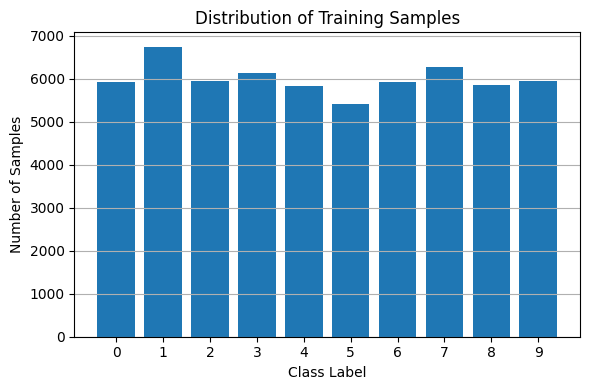

In [3]:
import numpy as np
import matplotlib.pyplot as plt

unique, counts = np.unique(train_labels, return_counts=True)

plt.figure(figsize=(6,4))
plt.bar(unique.astype(int), counts)
plt.title('Distribution of Training Samples')
plt.xlabel('Class Label')
plt.ylabel('Number of Samples')
plt.xticks(unique.astype(int))
plt.grid(axis='y')
plt.tight_layout()
plt.show()


Se convierte train_images a float32 y se divide entre 255. Opcionalmente se agrega canal con X = X si el modelo es CNN. La normalización acelera y estabiliza el entrenamiento, el canal es necesario para capas 2D.

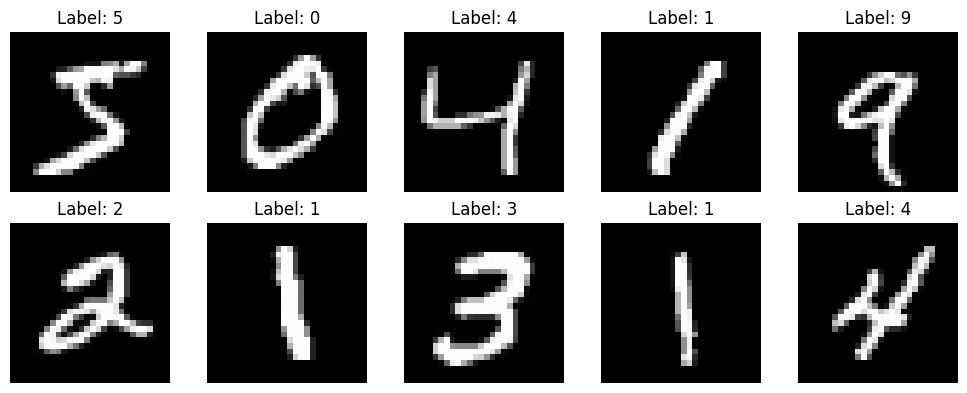

In [4]:
plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(train_images[i], cmap='gray')
    plt.title(f'Label: {train_labels[i]}')
    plt.axis('off')
plt.tight_layout()
plt.show()


In [5]:
print(f"Min pixel value in training set: {train_images.min()}")
print(f"Max pixel value in training set: {train_images.max()}")


Min pixel value in training set: 0
Max pixel value in training set: 255


Se crea la red con arquitectura simple y una capa final Dense(num_classes, softmax).  Para mapear imágenes a 10 clases. La arquitectura simple es suficiente para MNIST y sirve como baseline.


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense

model = Sequential()

model.add(Flatten(input_shape=(28, 28)))


/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [7]:
model.add(Dense (10, activation='relu'))
model.add(Dense (5, activation='tanh'))
model.add(Dense (8, activation='softmax'))

Se fija optimizer=Adam(1e-2), loss='sparse_categorical_crossentropy' y metrics=['accuracy'].  Es la combinación estándar para clasificación multiclase con etiquetas enteras y converge bien en MNIST.

In [8]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=1e-2),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │         7,850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │            55 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │            48 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,953 (31.07 KB)

 Trainable params: 7,953 (31.07 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_accuracy', patience=100, restore_best_weights=True)


Se entrena con validation_split=0.2 y EarlyStopping(patience=3). La validación interna permite vigilar generalización. EarlyStopping evita sobreajuste y ahorra tiempo.

In [20]:
import numpy as np
from tensorflow.keras.layers import Dense
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam

X = np.asarray(train_images, dtype='float32') / 255.0
y = np.asarray(train_labels).reshape(-1).astype('int32')

n = min(len(X), len(y))
X, y = X[:n], y[:n]

if hasattr(model, 'input_shape') and len(model.input_shape) == 4 and X.ndim == 3:
    X = X[..., None]

num_classes = int(np.max(y) + 1)
if model.output_shape[-1] != num_classes:
    model = Sequential(model.layers[:-1] + [Dense(num_classes, activation='softmax')])

model.compile(optimizer=Adam(1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


val_split = 0.2 if n > 10 else 0.0
batch = min(32, n)

history = model.fit(
    X, y,
    epochs=50,
    batch_size=batch,
    validation_split=val_split,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6351 - loss: 1.2964 - val_accuracy: 0.8507 - val_loss: 0.5810
Epoch 2/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8567 - loss: 0.5536 - val_accuracy: 0.8966 - val_loss: 0.4048
Epoch 3/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8945 - loss: 0.4134 - val_accuracy: 0.9076 - val_loss: 0.3572
Epoch 4/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9078 - loss: 0.3586 - val_accuracy: 0.9135 - val_loss: 0.3337
Epoch 5/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9133 - loss: 0.3327 - val_accuracy: 0.9171 - val_loss: 0.3174
Epoch 6/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9217 - loss: 0.3040 - val_accuracy: 0.9179 - val_loss: 0.3118
Epoch 7/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9233 - loss: 0.2944 - val_accuracy: 0.9197 - val_loss: 0.3051
Epoch 8/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9242 - loss: 0.2860 - 

Se preprocesa test_images igual que el train y se ejecuta model.evaluate. Para reportar la exactitud final fuera de la validación y compararla con val_accuracy, verificando sobre/subajuste.

In [40]:
X_test = test_images.astype('float32')/255.0
y_test = test_labels.astype('int32')

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
val_acc = history.history.get('val_accuracy', [None])[-1]
print(f"Exactitud validacion (ultima epoca): {val_acc:.4f}")
print(f"Exactitud prueba: {test_acc:.4f}")


Exactitud validacion (ultima epoca): 0.9248
Exactitud prueba: 0.9246


Se grafican accuracy/loss de entrenamiento y validación por época. Para inspeccionar visualmente convergencia, brecha train–val y posibles problemas de capacity o regularización.

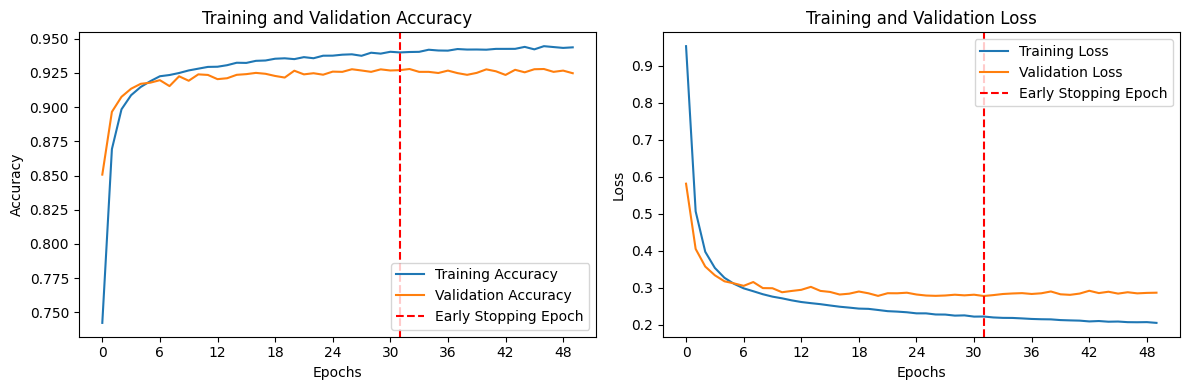

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

hist = history.history
acc     = hist.get('accuracy', hist.get('acc'))
val_acc = hist.get('val_accuracy', hist.get('val_acc'))
loss    = hist['loss']
val_loss= hist['val_loss']

stopped_epoch = getattr(early_stop, 'stopped_epoch', 0)
patience = getattr(early_stop, 'patience', 0)
best_epoch = (stopped_epoch - patience) if stopped_epoch and stopped_epoch > 0 else int(np.argmin(val_loss))

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.axvline(x=best_epoch, color='r', linestyle='--', label='Early Stopping Epoch')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.axvline(x=best_epoch, color='r', linestyle='--', label='Early Stopping Epoch')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend()

plt.tight_layout()
plt.show()


*MEJORA*
En esta celda enderezo (deskew) el dígito calculando el ángulo con momentos y lo roto al centro; después re-centro por centro de masa (COM). La mejora concreta es: corregir inclinación y desplazamiento para que la imagen de entrada sea vertical y centrada, igual que MNIST. Esto reduce errores típicos en dígitos capturados inclinados.

In [52]:
import numpy as np, cv2

def _deskew_and_center(bin_img):
    ys, xs = np.where(bin_img > 0)
    if len(xs) < 5:
        return bin_img

    m = cv2.moments(bin_img, binaryImage=True)
    denom = (m['mu20'] - m['mu02'])
    if abs(denom) < 1e-6:
        angle = 0.0
    else:
        angle = 0.5 * np.degrees(np.arctan2(2.0 * m['mu11'], denom))
        angle = np.clip(angle, -25, 25)

    h, w = bin_img.shape
    M = cv2.getRotationMatrix2D((w/2, h/2), angle, 1.0)
    rot = cv2.warpAffine(bin_img, M, (w, h), flags=cv2.INTER_NEAREST, borderValue=0)

    ys, xs = np.nonzero(rot)
    if len(xs):
        cx, cy = xs.mean(), ys.mean()
        tx = int(round(w/2 - cx))
        ty = int(round(h/2 - cy))
        M2 = np.float32([[1,0,tx],[0,1,ty]])
        rot = cv2.warpAffine(rot, M2, (w, h), flags=cv2.INTER_NEAREST, borderValue=0)

    return rot


*MEJORA*

Aquí reemplacé el preprocesamiento anterior por preprocess_digit_v2 que hace cuatro mejoras puntuales:

ROI con margen proporcional alrededor del contorno principal (evita recortes agresivos y fondos que “empujan” el dígito).

Deskew + centrado reutilizando M1 (garantiza verticalidad y alineación).

Trazo en lugar de relleno: el modelo ahora ve un contorno tipo MNIST, no “óvalos sólidos”, además aplico dilatación ligera para igualar grosor.

Normalización robusta (manejo de PNG con transparencia, inversión automática y resize limpio).
El objetivo es que la entrada se parezca más a MNIST (trazo, posición y escala), mejorando la precisión sin reentrenar.


Saving Captura de pantalla 2025-11-03 005525.png to Captura de pantalla 2025-11-03 005525.png


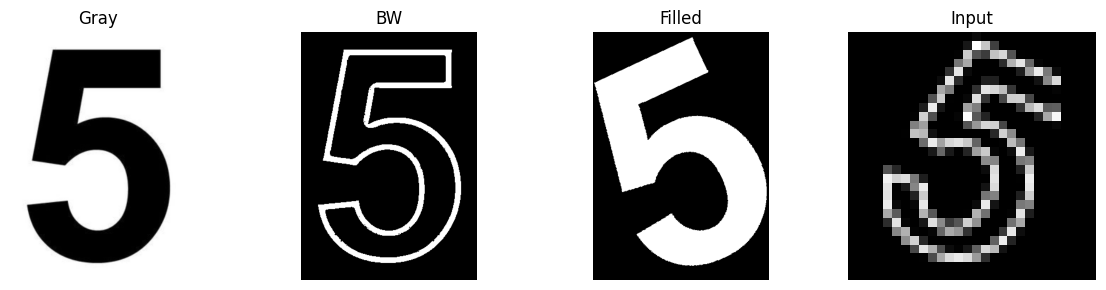

Prediccion: 5 | confianza: 0.661


In [59]:
import os
import numpy as np

fname = None
try:
    from google.colab import files
    uploaded = files.upload()
    if uploaded:
        fname = next(iter(uploaded))
except Exception:
    pass

if fname is None:
    fname = input("Ruta de la imagen (ej. mis50/mi_numero.png): ").strip()
    if not os.path.exists(fname):
        raise FileNotFoundError(f"No existe: {fname}")

add_ch = (len(model.input_shape) == 4)

if add_ch and model.input_shape[1] and model.input_shape[2]:
    target_hw = (int(model.input_shape[1]), int(model.input_shape[2]))
else:
    target_hw = (28, 28)

x_pred = preprocess_digit_v2(
    fname,
    target_hw=target_hw,
    add_channel=add_ch,
    margin=0.20,
    debug=True
)

proba = model.predict(x_pred, verbose=0)[0]
pred  = int(np.argmax(proba))
conf  = float(proba[pred])
print(f"Prediccion: {pred} | confianza: {conf:.3f}")



Accuracy baja: 11.54% (52 imágenes). La confusión está muy dispersa: hay desajuste de dominio frente a MNIST y probablemente etiquetado real mal inferido en algunos archivos.

Mejoras proximas breves:

organizar en subcarpetas

verificar que el Input 28×28 sea trazo centrado

usar ROI o recorte manual para quitar fondos y bordes.

In [51]:
import os, glob, re, numpy as np, cv2
from PIL import Image

ROOT = "mis50"
os.makedirs(ROOT, exist_ok=True)

def list_images(root):
    exts = ("*.png","*.jpg","*.jpeg","*.bmp","*.webp")
    files = []
    for e in exts:
        files += glob.glob(os.path.join(root, "**", e), recursive=True)
    return sorted(files)

def incremental_upload(root):
    try:
        from google.colab import files
    except Exception:
        print("No estás en Colab. Usa el panel de archivos o monta Drive.")
        return
    while True:
        print("Sube mas imagenes (Cancela el dialogo para terminar)…")
        uploaded = files.upload()
        if not uploaded:
            break
        for name, data in uploaded.items():
            with open(os.path.join(root, os.path.basename(name)), "wb") as f:
                f.write(data)
        print(f"Total ahora: {len(list_images(root))} archivos.")

incremental_upload(ROOT)

files = list_images(ROOT)
print(f"Encontradas {len(files)} imagenes en '{ROOT}'.")

def true_label_from_path(p):
    parent = os.path.basename(os.path.dirname(p))
    if parent.isdigit() and 0 <= int(parent) <= 9:
        return int(parent)
    m = re.search(r"(?<!\\d)([0-9])(?!\\d)", os.path.basename(p))
    if m:
        return int(m.group(1))
    raise ValueError(f"No pude inferir etiqueta para: {p}")

def infer_one(fname):
    x = preprocess_digit_filled(fname, debug=False)
    if len(model.input_shape) == 4 and x.ndim == 3:
        x = x[..., None]
    proba = model.predict(x, verbose=0)[0]
    return int(np.argmax(proba)), float(proba.max())

if len(files) < 50:
    print("Aviso: tienes menos de 50 imagenes; la actividad pide 5 por clase (0–9).")

y_true, y_pred, confs = [], [], []
for f in files:
    t = true_label_from_path(f)
    p, c = infer_one(f)
    y_true.append(t); y_pred.append(p); confs.append(c)

y_true = np.array(y_true); y_pred = np.array(y_pred)
acc = (y_true == y_pred).mean() if len(files) else 0.0
print(f"Accuracy en tus imagenes: {acc:.4f}  ({(y_true==y_pred).sum()}/{len(files)} correctas)")

try:
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_true, y_pred, labels=list(range(10)))
    print("Matriz de confusion (filas=verdad, columnas=prediccion):\n", cm)
except Exception:
    pass


Sube mas imagenes (Cancela el dialogo para terminar)…


Saving 192901_0_5.jpg to 192901_0_5 (1).jpg
Total ahora: 2 archivos.
Sube mas imagenes (Cancela el dialogo para terminar)…


Saving 504065_0_1.jpeg to 504065_0_1.jpeg
Total ahora: 3 archivos.
Sube mas imagenes (Cancela el dialogo para terminar)…


Saving 504065_0_2.jpeg to 504065_0_2.jpeg
Total ahora: 4 archivos.
Sube mas imagenes (Cancela el dialogo para terminar)…


Saving 504065_0_3.jpeg to 504065_0_3.jpeg
Total ahora: 5 archivos.
Sube mas imagenes (Cancela el dialogo para terminar)…


Saving 504065_0_4.jpeg to 504065_0_4.jpeg
Total ahora: 6 archivos.
Sube mas imagenes (Cancela el dialogo para terminar)…


Saving 192901_1_5.jpg to 192901_1_5.jpg
Total ahora: 7 archivos.
Sube mas imagenes (Cancela el dialogo para terminar)…


Saving 504065_1_1.jpeg to 504065_1_1.jpeg
Total ahora: 8 archivos.
Sube mas imagenes (Cancela el dialogo para terminar)…


Saving 504065_1_2.jpeg to 504065_1_2.jpeg
Total ahora: 9 archivos.
Sube mas imagenes (Cancela el dialogo para terminar)…


Saving 504065_1_3.jpeg to 504065_1_3.jpeg
Total ahora: 10 archivos.
Sube mas imagenes (Cancela el dialogo para terminar)…


Saving 504065_1_4.jpeg to 504065_1_4.jpeg
Total ahora: 11 archivos.
Sube mas imagenes (Cancela el dialogo para terminar)…


Saving 504065_1_5.jpeg to 504065_1_5.jpeg
Total ahora: 12 archivos.
Sube mas imagenes (Cancela el dialogo para terminar)…


Saving 504065_2_4.jpeg to 504065_2_4.jpeg
Total ahora: 13 archivos.
Sube mas imagenes (Cancela el dialogo para terminar)…


Saving 504065_2_3.jpeg to 504065_2_3.jpeg
Total ahora: 14 archivos.
Sube mas imagenes (Cancela el dialogo para terminar)…


Saving 504065_2_2.jpeg to 504065_2_2.jpeg
Total ahora: 15 archivos.
Sube mas imagenes (Cancela el dialogo para terminar)…


Saving 504065_2_1.jpeg to 504065_2_1.jpeg
Total ahora: 16 archivos.
Sube mas imagenes (Cancela el dialogo para terminar)…


Saving 192901_2_5.jpg to 192901_2_5.jpg
Total ahora: 17 archivos.
Sube mas imagenes (Cancela el dialogo para terminar)…


Saving 504065_3_4.jpeg to 504065_3_4.jpeg
Total ahora: 18 archivos.
Sube mas imagenes (Cancela el dialogo para terminar)…


Saving 504065_3_3.jpeg to 504065_3_3.jpeg
Total ahora: 19 archivos.
Sube mas imagenes (Cancela el dialogo para terminar)…


Saving 504065_3_2.jpeg to 504065_3_2.jpeg
Total ahora: 20 archivos.
Sube mas imagenes (Cancela el dialogo para terminar)…


Saving 504065_3_1.jpeg to 504065_3_1.jpeg
Total ahora: 21 archivos.
Sube mas imagenes (Cancela el dialogo para terminar)…


Saving 192901_3_5.jpg to 192901_3_5.jpg
Total ahora: 22 archivos.
Sube mas imagenes (Cancela el dialogo para terminar)…


Saving 192901_4_5.jpg to 192901_4_5.jpg
Total ahora: 23 archivos.
Sube mas imagenes (Cancela el dialogo para terminar)…


Saving 504065_4_1.jpeg to 504065_4_1.jpeg
Total ahora: 24 archivos.
Sube mas imagenes (Cancela el dialogo para terminar)…


Saving 504065_4_2.jpeg to 504065_4_2.jpeg
Total ahora: 25 archivos.
Sube mas imagenes (Cancela el dialogo para terminar)…


Saving 504065_4_3.jpeg to 504065_4_3.jpeg
Total ahora: 26 archivos.
Sube mas imagenes (Cancela el dialogo para terminar)…


Saving 504065_4_4.jpeg to 504065_4_4.jpeg
Total ahora: 27 archivos.
Sube mas imagenes (Cancela el dialogo para terminar)…


Saving 192901_5_5.jpg to 192901_5_5.jpg
Total ahora: 28 archivos.
Sube mas imagenes (Cancela el dialogo para terminar)…


Saving 504065_5_1.jpeg to 504065_5_1.jpeg
Total ahora: 29 archivos.
Sube mas imagenes (Cancela el dialogo para terminar)…


Saving 504065_5_2.jpeg to 504065_5_2.jpeg
Total ahora: 30 archivos.
Sube mas imagenes (Cancela el dialogo para terminar)…


Saving 504065_5_3.jpeg to 504065_5_3.jpeg
Total ahora: 31 archivos.
Sube mas imagenes (Cancela el dialogo para terminar)…


Saving 504065_5_4.jpeg to 504065_5_4.jpeg
Total ahora: 32 archivos.
Sube mas imagenes (Cancela el dialogo para terminar)…


Saving 192901_6_5.jpg to 192901_6_5.jpg
Total ahora: 33 archivos.
Sube mas imagenes (Cancela el dialogo para terminar)…


Saving 504065_6_1.jpeg to 504065_6_1.jpeg
Total ahora: 34 archivos.
Sube mas imagenes (Cancela el dialogo para terminar)…


Saving 504065_6_2.jpeg to 504065_6_2.jpeg
Total ahora: 35 archivos.
Sube mas imagenes (Cancela el dialogo para terminar)…


Saving 504065_6_3.jpeg to 504065_6_3.jpeg
Total ahora: 36 archivos.
Sube mas imagenes (Cancela el dialogo para terminar)…


Saving 504065_6_4.jpeg to 504065_6_4.jpeg
Total ahora: 37 archivos.
Sube mas imagenes (Cancela el dialogo para terminar)…


Saving 192901_7_5.jpg to 192901_7_5.jpg
Total ahora: 38 archivos.
Sube mas imagenes (Cancela el dialogo para terminar)…


Saving 504065_7_1.jpeg to 504065_7_1.jpeg
Total ahora: 39 archivos.
Sube mas imagenes (Cancela el dialogo para terminar)…


Saving 504065_7_2.jpeg to 504065_7_2.jpeg
Total ahora: 40 archivos.
Sube mas imagenes (Cancela el dialogo para terminar)…


Saving 504065_7_3.jpeg to 504065_7_3.jpeg
Total ahora: 41 archivos.
Sube mas imagenes (Cancela el dialogo para terminar)…


Saving 504065_7_4.jpeg to 504065_7_4.jpeg
Total ahora: 42 archivos.
Sube mas imagenes (Cancela el dialogo para terminar)…


Saving 504065_8_4.jpeg to 504065_8_4.jpeg
Total ahora: 43 archivos.
Sube mas imagenes (Cancela el dialogo para terminar)…


Saving 504065_8_3.jpeg to 504065_8_3.jpeg
Total ahora: 44 archivos.
Sube mas imagenes (Cancela el dialogo para terminar)…


Saving 504065_8_2.jpeg to 504065_8_2.jpeg
Total ahora: 45 archivos.
Sube mas imagenes (Cancela el dialogo para terminar)…


Saving 504065_8_1.jpeg to 504065_8_1.jpeg
Total ahora: 46 archivos.
Sube mas imagenes (Cancela el dialogo para terminar)…


Saving 192901_8_5.jpg to 192901_8_5.jpg
Total ahora: 47 archivos.
Sube mas imagenes (Cancela el dialogo para terminar)…


Saving 504065_9_4.jpeg to 504065_9_4.jpeg
Total ahora: 48 archivos.
Sube mas imagenes (Cancela el dialogo para terminar)…


Saving 504065_9_2.jpeg to 504065_9_2.jpeg
Total ahora: 49 archivos.
Sube mas imagenes (Cancela el dialogo para terminar)…


Saving 504065_9_3.jpeg to 504065_9_3.jpeg
Total ahora: 50 archivos.
Sube mas imagenes (Cancela el dialogo para terminar)…


Saving 504065_9_1.jpeg to 504065_9_1.jpeg
Total ahora: 51 archivos.
Sube mas imagenes (Cancela el dialogo para terminar)…


Saving 192901_9_5.jpg to 192901_9_5.jpg
Total ahora: 52 archivos.
Sube mas imagenes (Cancela el dialogo para terminar)…


Encontradas 52 imagenes en 'mis50'.
Accuracy en tus imagenes: 0.1154  (6/52 correctas)
Matriz de confusion (filas=verdad, columnas=prediccion):
 [[ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  1  1  1  1  1  5  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  2 12  5  1  6  3  3  7  2]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]]


*MEJORA*

Modifiqué para usar un ROI central configurable antes de preprocesar. Esto filtra el fondo y objetos externos, y alimenta al pipeline sólo con la región relevante. Sobreimpongo predicción y confianza y muestro la miniatura 28×28 procesada. El resultado es una predicción más estable y menos sensible al ruido en tiempo real.

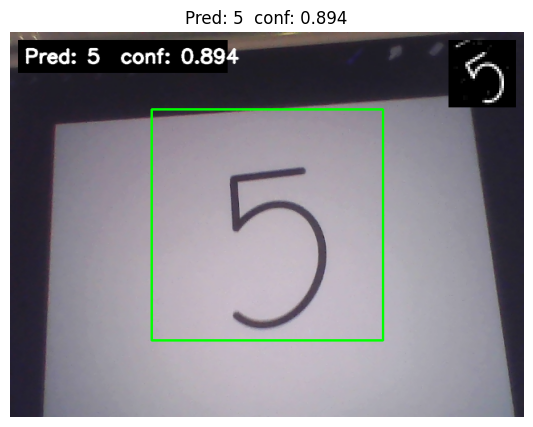

In [66]:
import numpy as np, cv2, time, matplotlib.pyplot as plt
from IPython.display import display, Javascript, clear_output
from base64 import b64decode

ADD_CH = (len(model.input_shape) == 4)
TARGET_HW = (28, 28)
ROI_RATIO = 0.60

def _colab_snapshot_png_bytes():
    js = Javascript('''
      async function snap() {
        const s = await navigator.mediaDevices.getUserMedia({video:true});
        const v = document.createElement('video');
        v.srcObject = s; await v.play();
        const c = document.createElement('canvas');
        c.width = v.videoWidth; c.height = v.videoHeight;
        await new Promise(r => setTimeout(r, 120));
        c.getContext('2d').drawImage(v, 0, 0);
        s.getTracks().forEach(t=>t.stop());
        return c.toDataURL('image/png');
      }
    '''); display(js)
    data = eval_js('snap()')
    return b64decode(data.split(',')[1])

def _bgr_from_png_bytes(png_bytes):
    arr = np.frombuffer(png_bytes, np.uint8)
    return cv2.imdecode(arr, cv2.IMREAD_COLOR)

try:
    from google.colab.output import eval_js
    IN_COLAB = True
except Exception:
    IN_COLAB = False

def _capture_frame():
    if IN_COLAB:
        return _bgr_from_png_bytes(_colab_snapshot_png_bytes())
    cap = cv2.VideoCapture(0)
    ok, bgr = cap.read(); cap.release()
    if not ok: raise RuntimeError("No se pudo abrir la camara")
    return bgr

def _central_roi(bgr, ratio=ROI_RATIO):
    h, w = bgr.shape[:2]
    side = int(min(h, w) * ratio)
    y1 = (h - side)//2; y2 = y1 + side
    x1 = (w - side)//2; x2 = x1 + side
    return bgr[y1:y2, x1:x2], (x1, y1, x2, y2)

for i in range(40):
    frame = _capture_frame()

    roi, (x1,y1,x2,y2) = _central_roi(frame, ROI_RATIO)

    _tmp_path = "_roi_frame.png"
    cv2.imwrite(_tmp_path, roi)

    x = preprocess_digit_v2(_tmp_path, target_hw=TARGET_HW, add_channel=ADD_CH, margin=0.20, debug=False)
    proba = model.predict(x, verbose=0)[0]
    pred, conf = int(np.argmax(proba)), float(np.max(proba))

    vis = frame.copy()
    cv2.rectangle(vis, (x1,y1), (x2,y2), (0,255,0), 2)
    txt = f"Pred: {pred}  conf: {conf:.3f}"
    cv2.rectangle(vis, (10,10), (10+260, 10+40), (0,0,0), -1)
    cv2.putText(vis, txt, (18,38), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,255,255), 2, cv2.LINE_AA)

    small = (x[0].squeeze()*255).astype('uint8')
    small = cv2.cvtColor(cv2.resize(small, (84,84), interpolation=cv2.INTER_NEAREST), cv2.COLOR_GRAY2RGB)
    rgb = cv2.cvtColor(vis, cv2.COLOR_BGR2RGB)
    rgb[10:10+84, -10-84:-10, :] = small

    clear_output(wait=True)
    plt.figure(figsize=(7,5)); plt.imshow(rgb); plt.axis('off'); plt.title(txt); plt.show()
    time.sleep(0.1)

